# Quantum Approximate Optimization Algorithm

Enable a more flexible and performance-efficient handling of type annotations, particularly useful for forward referencing and static type checking.

In [1]:
from __future__ import annotations

In [2]:
import numpy as np
import networkx as nx

Creates a graph `G` using NetworkX's from_numpy_array function. The function takes the adjacency matrix `w` as input and creates a graph where the nodes are represented by integers 0 to 3 (for a 4x4 matrix), and edges are added between nodes if the corresponding element in the matrix is non-zero.

In [3]:
num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

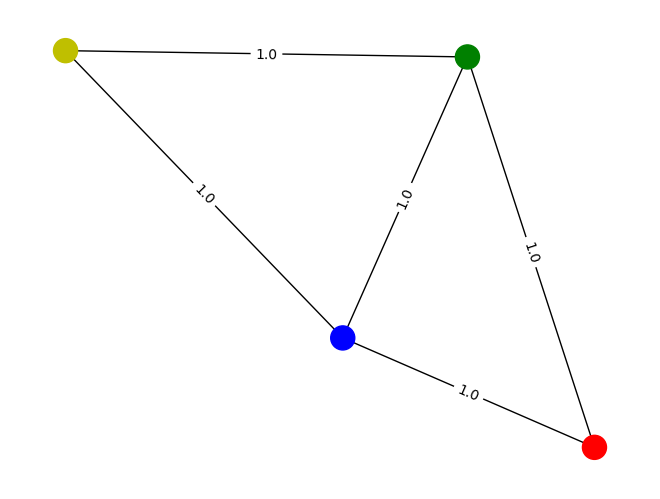

In [6]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

# Brute-force classical method

Computes the value of a cut in a graph, given a binary string representing a subset of nodes and the graph's adjacency matrix.

Creating the Matrix X:
    `X = np.outer(x, (1 - x))` computes the outer product of the vector `x` and its complement `(1 - x)`.
    This matrix `X` essentially identifies edges that cross between the two partitions. If node `i` is in one partition and node `j` is in the other, the corresponding element in X will be 1; otherwise, it will be 0.

In [7]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array. 
           Each element in this array corresponds to a node in the graph, and its value (0 or 1) indicates which of the two partitions the node belongs to.
        w: Adjacency matrix. Square matrix where w[i, j] indicates weight of the edge between nodes i and j.
           For an unweighted graph, this would be 0 (no edge) or 1 (edge present).
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x)) 
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X) # Effectively counting the number of edges that would need to be "cut" if the graph were partitioned according to x.

Birfield convert an integer `n` into a binary representation of a specified length `L`, and return this binary representation as a list of integers (0s and 1s).

In [8]:
def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L) #convert the integer n into its binary representation as a string. 
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

Brute-force method. Try all the binary assignments

In [9]:
# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L 
sol = np.inf #Inifinity to keep track of the best (minimum) objective value found.

#Brute force search
for i in range(max):
    # Generates the binary representation of the number `i` with `L`` bits. Each bit represents whether a node is in one partition or the other.
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur) #Counts how many nodes are in one of the partitions
    
    # For the partition to be balanced, the number of nodes in partition 'A' times 2 should equal the total number of nodes L. 
    # This ensures that both partitions A and B have the same number of nodes.
    if how_many_nonzero * 2 != L:  # not balanced, skip to next iteration
        continue
    
    # If the partition is balanced, the code proceeds to calculate the "cut" value of this particular partitioning.
    cur_v = objective_value(np.array(cur), w) # Calculates the value of the cut for the current partitioning
    if cur_v < sol:
        sol = cur_v #Update to best minimum value found so far.

print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


# QAOA method

In [10]:
from qiskit.quantum_info import Pauli, SparsePauliOp

The graph partition problem can be converted to an Ising Hamiltonian

[Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843)
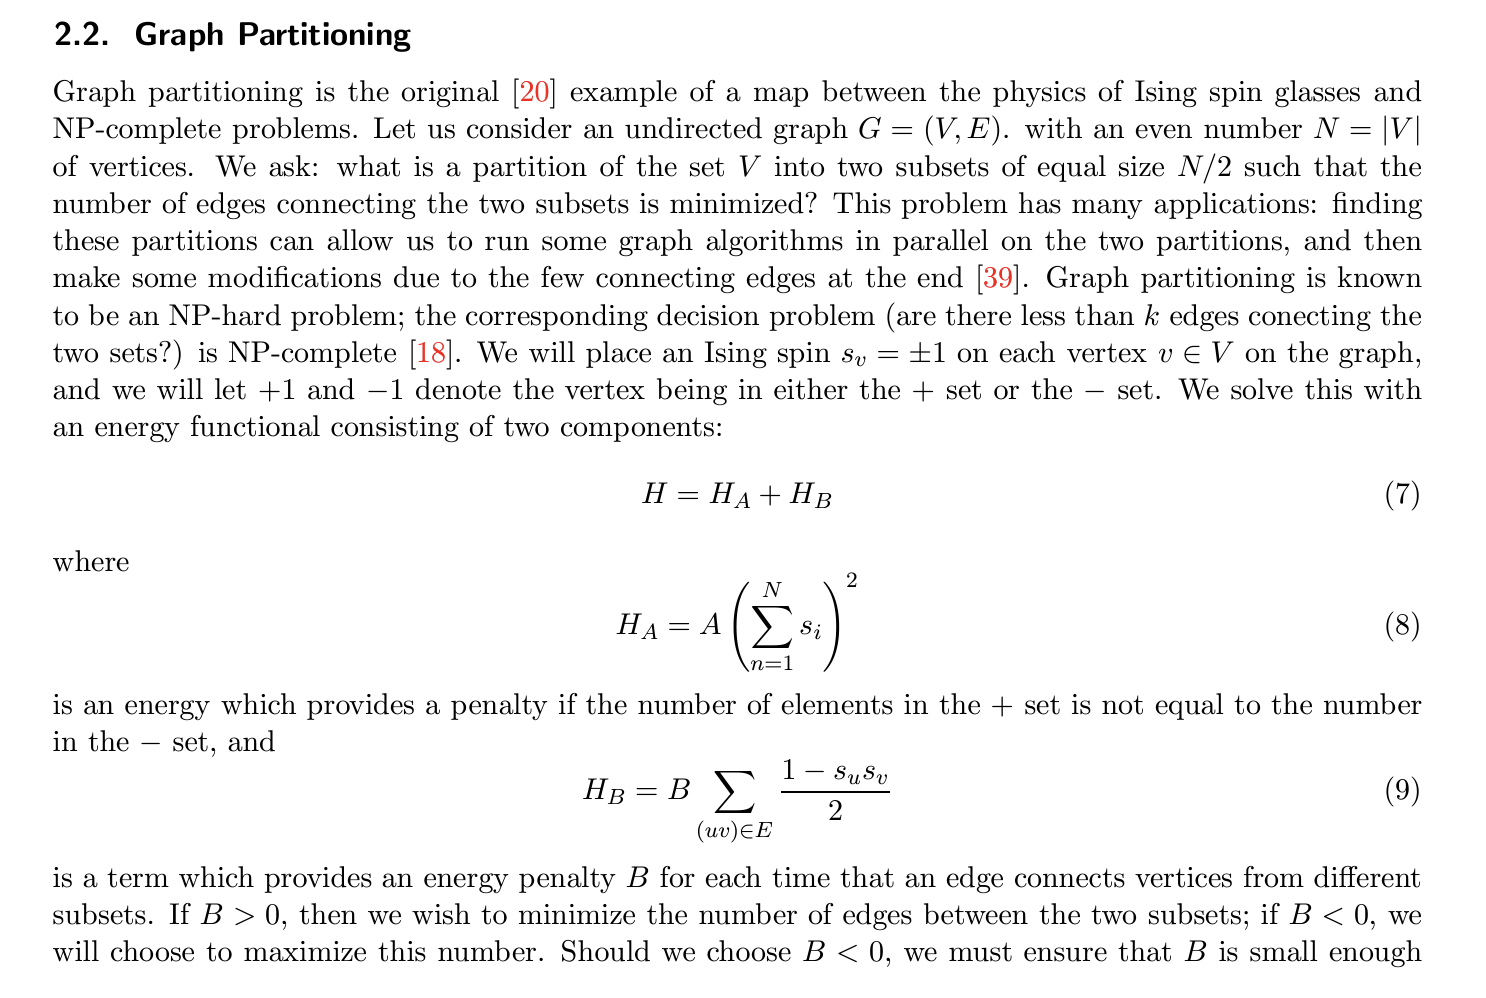

\begin{equation}
H=H_A+H_B

\end{equation}

\begin{equation}
H_A = \sum_{(i,j)\in E}{(1-Z_iZ_j)/2}

\end{equation}

\begin{equation}
H_B = (\sum_{i}{Z_i})^2 = \sum_{i}{Z_i^2}+\sum_{i!=j}{Z_iZ_j}
\end{equation}
$H_A$ is for achieving goal 2 and $H_B$ is for achieving goal 1.

Goals:

            1 Separate the vertices into two set of the same size.

            2 Make sure the number of edges between the two set is minimized.

In [11]:
def get_operator(weight_matrix: np.ndarray) -> tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    """
    Constructing H_A (Minimize Edges Between Partitions)
    
    """
    #  Iterates over all pairs of nodes (i, j) in the lower triangle of the adjacency matrix.
    for i in range(num_nodes):
        for j in range(i):
            # Checks if an edge exists between nodes i and j.
            if weight_matrix[i, j] != 0:
                # x_p, z_p: Initializes two arrays of length num_nodes representing the X and Z components of a Pauli operator. Initially, all elements are False.
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                # Sets z_p[i] and z_p[j] to True, indicating the application of Pauli-Z operators on qubits i and j.
                z_p[i] = True
                z_p[j] = True
                # Appends the Pauli operator (constructed from z_p and x_p) to pauli_list.
                pauli_list.append(Pauli((z_p, x_p)))
                # Appends a coefficient of -0.5 to coeffs and increases the shift by 0.5 for each edge.
                coeffs.append(-0.5)
                shift += 0.5

    """
    Constructing H_B (Equal Size Partitions)
    """
    for i in range(num_nodes):
        for j in range(num_nodes):
            # For each pair where i != j, it does the same procedure as above to create and append a Pauli operator, but with a coefficient of 1.0 this time.
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            # For the case i == j (the diagonal of the matrix), it increments the shift by 1.
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

qubit_op, offset = get_operator(w)

In [12]:
print(qubit_op)

SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IIZZ', 'IZZI', 'ZIZI', 'IZIZ', 'IZZI', 'ZZII', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j])


In [13]:
print(f'Objective value computed by the Qiskit operator is {offset}')

Objective value computed by the Qiskit operator is 6.5


So lets use the QAOA algorithm to find the solution.

The `Sampler` class is a part of Qiskit's primitives framework, which provides a higher-level interface for executing quantum circuits.

## Role in Quantum Algorithms
- In quantum algorithms like QAOA or VQE, you often need to repeatedly measure the output of quantum circuits to get statistical information about the quantum state.

- The Sampler automates and optimizes this process. It runs the circuit many times (each run is called a "shot") and aggregates the results into a probability distribution or a count dictionary, where the keys are bitstrings (representing quantum states) and the values are the number of times each bitstring was observed.

In [14]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli, Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals

sampler = Sampler()

/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_48852/4142094599.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import QAOA


`sample_most_likely` function determine the most probable binary string representation from a given quantum state.

In [16]:
def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """

    # Check the type of input and extract the informatino to `values`
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector

    # Calculates the number of qubits (n) represented by the state vector.
    n = int(np.log2(len(values)))
    # Identify the Most Likely State
    k = np.argmax(np.abs(values))
    # Converts the index k to a binary string of length n.
    x = bitfield(k, n)
    # Reverses the binary string.
    x.reverse()
    return np.asarray(x)

## COBYLA Optimizer

COBYLA is a numerical optimization method used to find an approximate solution to problems with constraints. In the context of QAOA, the optimizer is used to find the optimal parameters (angles) for the quantum circuit that minimize the objective function.

In [17]:
algorithm_globals.random_seed = 10598

optimizer = COBYLA()

# Initialize qaoa algorithm
qaoa = QAOA(sampler, optimizer, reps=2)

"""
Runs the QAOA algorithm on the quantum Hamiltonian (qubit_op) which encodes your graph partitioning problem. 
The algorithm aims to find the state that minimizes the Hamiltonian's value, effectively solving the optimization problem.
"""
result = qaoa.compute_minimum_eigenvalue(qubit_op)

"""
After QAOA is executed, `result.eigenstate` contains the quantum state that represents the solution. 
`sample_most_likely` is used to extract the most probable binary string from this state, which corresponds to the solution of your problem.
"""
x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {objective_value(x, w)}')

/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_48852/2728529595.py:1: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 10598


[1 0 1 0]
Objective value computed by QAOA is 3


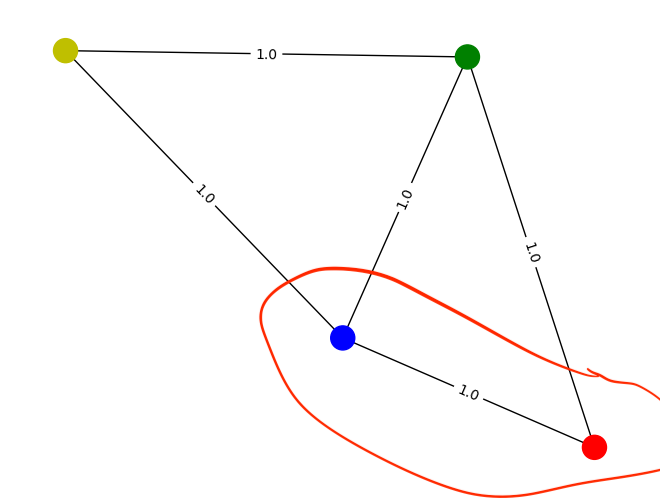

Another example: https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html

# Just Example with VQE for reference

In [18]:
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, "ry", "cz", reps=2, entanglement="linear")
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer)

result = sampling_vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by VQE is {objective_value(x, w)}")

/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_48852/2995033002.py:5: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 10598


[0 1 0 1]
Objective value computed by VQE is 3
